# Coverage Stats and Plot for Paper on Photometry

In [ ]:
from astropy.wcs import WCS
from astropy.io import fits 
from astropy.visualization import ZScaleInterval
from astropy.coordinates import SkyCoord
import astropy.units as u 

import glob 
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

from regions import PixCoord
from regions import RectangleSkyRegion, RectanglePixelRegion, PolygonPixelRegion

import os
data_dir = os.getenv("DATADIR")


#### Step 1: get the footprints

In [ ]:
def get_files(uvfilter,galaxy):
    # Where SWIFT data is stored
    file_location = f'H:/Data/SUMS_Tractor_Data/{galaxy}/original_data'
    # Get All Files For that Filter and Galaxy
    fname = glob.glob(f"{file_location}/*{uvfilter}*.new")
    n_total_files = len(fname)
    # Files with tracking issues 
    tracking_df = pd.read_csv(data_dir+'0_SUMS_Catalogs/CompleteCatalog/MaskedSources/files_with_tracking_issues.csv')
    if uvfilter == 'um2':
        uvfilter = 'uvm2' 
    if uvfilter == 'uw1':
        uvfilter = 'uvw1'
    if uvfilter == 'uw2':
        uvfilter = 'uvw2'
    bad_files = tracking_df.loc[(tracking_df['galaxy'] == galaxy.lower()) & (tracking_df['filter'] == 'uvm2'),'files']
    # Remove files with tracking issues
    used_fnames = []
    for f in fname:
        name = f.split('sk_')[1].split('.new')[0] 
        if name not in bad_files.values:
            used_fnames.append(f)
    n_files = len(used_fnames)
    return used_fnames, n_files, n_total_files

def get_UVOT_corners(file):
    # Detector coordinates from Maria's code in RetrieveSource.
    corners = [
        [-8.988, 8.810, 8.891,-8.713],
        [9.128, 9.040, -9.178,-8.989],
    ] 
    # Turn off warnings about SIP distortion 
    hdr = fits.open(file)[0].header
    hdr['CTYPE1D'] = 'DETX -SIP'
    hdr['CTYPE2D'] = 'DETY -SIP'
    # Convert coordinates
    x, y = WCS(hdr, key="D").all_world2pix(corners[0], corners[1], 0)
    r, d = WCS(hdr).all_pix2world(x, y, 0)
    return r,d

def get_all_uvot_corners(uvfilter,galaxy):
    fname,_,_ = get_files(uvfilter,galaxy)
    # Get UVOT corners
    all_corners = []
    for f in fname:
        all_corners.append(get_UVOT_corners(f))
    return all_corners

# Transform UVOT coordinates to be put on Anna's Images
def get_anna_coords(r,d,optical_hdu):
    x2,y2 = WCS(optical_hdu,naxis=2).all_world2pix(r,d,0)
    return x2,y2

def get_all_anna_corners(uvfilter,galaxy,optical_hdu,r,d):
    fname,_,_ = get_files(uvfilter,galaxy)
    # Get UVOT corners
    all_corners = []
    for f in fname:
        all_corners.append(get_anna_coords(f,optical_hdu,r,d))
    return all_corners

# Get Anna's Image
dir = "C:/Projects/0_Data/MagellanicCloudPhotos"
lmc_optical_hdu = fits.open(f'{dir}/anna_lmc.fits')[0]
smc_optical_hdu = fits.open(f'{dir}/anna_smc.fits')[0]

# Get Corners
lmc_um2_corners = get_all_uvot_corners('um2','LMC')
lmc_uw2_corners = get_all_uvot_corners('uw2','LMC')
lmc_uw1_corners = get_all_uvot_corners('uw1','LMC')

smc_um2_corners = get_all_uvot_corners('um2','SMC')
smc_uw2_corners = get_all_uvot_corners('uw2','SMC')
smc_uw1_corners = get_all_uvot_corners('uw1','SMC')


#### Step 2: Calculate Coverage for LMC

Area:  10.656 deg2


(1000.0, 2250.0)

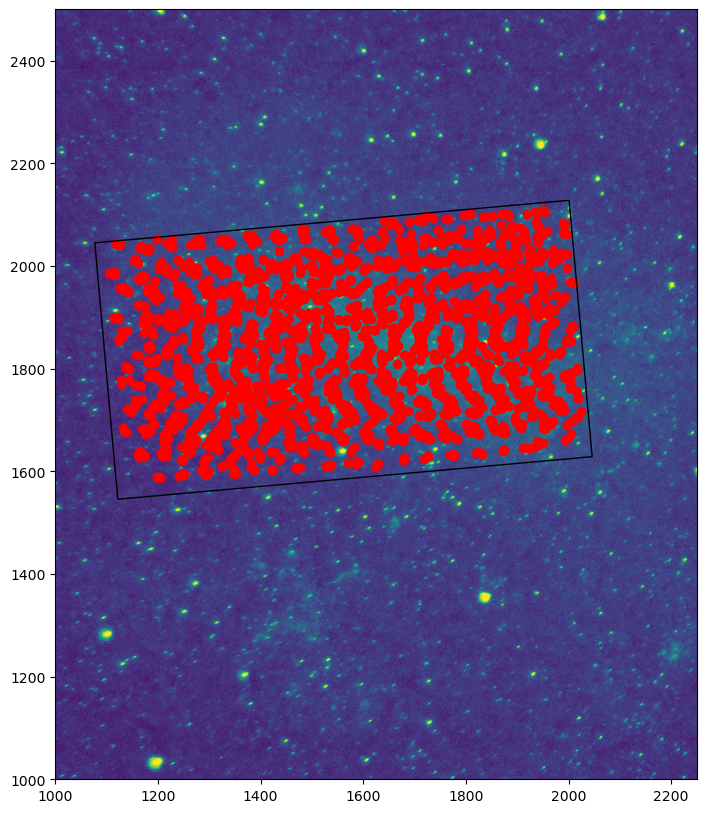

In [189]:
plt.figure(figsize=(10,10))


# Plot all coordinates 
all_r = np.array([corner[0] for corner in lmc_um2_corners]).flatten()
all_d = np.array([corner[1] for corner in lmc_um2_corners]).flatten()
d = {'r':all_r,'d':all_d}
df = pd.DataFrame(data=d)
all_x,all_y = get_anna_coords(df.r,df.d,lmc_optical_hdu)
plt.scatter(all_x,all_y,c='r')


# Figure out the center coordinate 
# lower Left
ll = [np.min(all_r),np.min(all_d)]
# Lower Right
lr = [np.max(all_r),np.min(all_d)]
# Upper Left 
ul = [np.min(all_r),np.max(all_d)]
# Upper Right
ur = [np.max(all_r),np.max(all_d)]

co_ll = SkyCoord(ll[0],ll[1],unit='degree')
co_lr = SkyCoord(lr[0],lr[1],unit='degree')
co_ul = SkyCoord(ul[0],ul[1],unit='degree')
co_ur = SkyCoord(ur[0],ur[1],unit='degree')

c_x = (co_ll.ra.degree + co_lr.ra.degree) / 2
c_y = (co_ll.dec.degree + co_ul.dec.degree) / 2

center_sky = SkyCoord(c_x, c_y, unit='deg', frame='fk5')

# Estimate the width and height 
width = 4.44*u.deg
height = 2.4*u.deg
angle= 3*u.deg

# Plot a rectangle 
region_sky = RectangleSkyRegion(center=center_sky,
                                width= width,height=height,angle=angle)

wcs = WCS(lmc_optical_hdu,naxis=2)
pixel_region = region_sky.to_pixel(wcs)
pixel_region.plot()

# Plot the image 
img = lmc_optical_hdu.data[0]#.T
plt.imshow(img)

# Print the area 
area = width * height
print(f'Area: ',area)

plt.ylim(1000,2500)
plt.xlim(1000,2250)

#### Step 3: Calculate Coverage for SMC

Area:  3.830602015323019 deg2


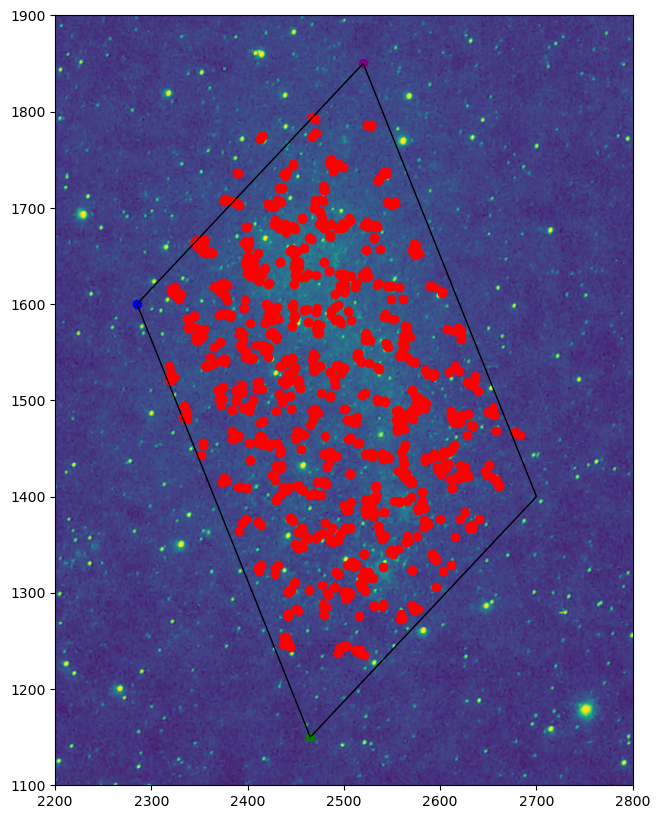

In [190]:
plt.figure(figsize=(10,10))

# Plot all coordinates 
all_r = np.array([corner[0] for corner in smc_um2_corners]).flatten()
all_d = np.array([corner[1] for corner in smc_um2_corners]).flatten()
d = {'r':all_r,'d':all_d}
df = pd.DataFrame(data=d)
all_x,all_y = get_anna_coords(df.r,df.d,smc_optical_hdu)
plt.scatter(all_x,all_y,c='r')


# Plot Image
wcs = WCS(smc_optical_hdu,naxis=2)
img = smc_optical_hdu.data[0]#.T

# This one is harder 
vertices = PixCoord(x=[2285, 2520, 2700,2465], y=[1600, 1850, 1400,1150])
region_pix = PolygonPixelRegion(vertices=vertices)

coords = region_pix.to_sky(wcs)
width = coords.vertices[0].separation(coords.vertices[1]).degree * u.deg
height = coords.vertices[0].separation(coords.vertices[3]).degree * u.deg

# Print the area 
area = width * height
print(f'Area: ',area)

top_left = coords.vertices[0].to_pixel(wcs)
plt.scatter(top_left[0],top_left[1],c='b')
bottom_left = coords.vertices[3].to_pixel(wcs)
plt.scatter(bottom_left[0],bottom_left[1],c='g')
top_right = coords.vertices[1].to_pixel(wcs)
plt.scatter(top_right[0],top_right[1],c='purple')

plt.imshow(img)
plt.xlim(2200,2800)
plt.ylim(1100,1900)
region_pix.plot()

#### Step 4: Determine how many images we have total

In [ ]:
# How many fields are there in each filter, and total? 

for galaxy in ['LMC','SMC']:
    n_all = []
    n_used = []
    for uvfilter in ['um2','uw2','uw1']:
        _,n_files,n_total_files = get_files(uvfilter,galaxy)
        n_all.append(n_total_files)
        n_used.append(n_files)
        print(f'{galaxy} {uvfilter}: Total files {n_total_files}; Used files {n_files}')
    print(f'{galaxy} Total: Total files {np.sum(n_all)}; NUsed files {np.sum(n_used)}')
    print('')
get_files(uvfilter,galaxy)

lmc_total =  len(lmc_um2_corners)+len(lmc_uw2_corners)+len(lmc_uw1_corners)
smc_total =  len(smc_um2_corners)+len(smc_uw2_corners)+len(smc_uw1_corners)
print(f'Number of files for LMC UVM2: ', len(lmc_um2_corners))
print(f'Number of files for LMC UVW2: ', len(lmc_uw2_corners))
print(f'Number of files for LMC UVW1: ', len(lmc_uw1_corners))
print(f'Number of files for LMC Total: ', lmc_total)
print('')
print(f'Number of files for SMC UVM2: ', len(smc_um2_corners))
print(f'Number of files for SMC UVW2: ', len(smc_uw2_corners))
print(f'Number of files for SMC UVW1: ', len(smc_uw1_corners))
print(f'Number of files for SMC Total: ', smc_total )

LMC um2: Total files 663; Used files 617
LMC uw2: Total files 686; Used files 640
LMC uw1: Total files 631; Used files 593
LMC Total: Total files 1980; NUsed files 1850

SMC um2: Total files 219; Used files 197
SMC uw2: Total files 225; Used files 203
SMC uw1: Total files 212; Used files 192
SMC Total: Total files 656; NUsed files 592



In [192]:
# Files dropped 

smc_sus_uvw1 = ['40415_1_3', '40416_1_1', '40416_1_2', '40421_2_1', '40421_2_2', 
            '40421_4_2', '40423_1_1', '40426_4_2', '40427_3_1', '40427_3_2', 
            '40428_2_1', '40428_2_2', '40429_1_2', '40430_2_2', '40431_2_1', 
            '40433_1_1', '40434_2_2', '40435_3_1', '40436_2_1', '40436_2_2', 
            '40445_3_2', '40445_3_3', '40448_2_4', '40454_1_2', '40457_1_2', '40458_2_2', '40461_1_4']

smc_sus_uvm2 = ['40415_1_2', '40416_1_2', '40419_2_1', '40421_2_2', '40421_4_1',
           '40421_4_3', '40426_4_2', '40427_3_1', '40428_2_1', '40428_2_3',
           '40429_1_2', '40433_1_1', '40433_4_1', '40434_2_2', '40436_2_1',
           '40436_2_2', '40444_1_2', '40445_3_1', '40451_1_3', '40453_1_2',
           '40454_1_2', '40457_1_2']

smc_sus_uvw2 = ['40415_1_2', '40419_1_2', '40419_2_1', '40421_4_1', '40421_4_4', 
            '40425_4_1', '40425_4_3', '40426_4_1', '40426_4_2', '40427_3_1', 
            '40427_3_2', '40428_1_2', '40428_2_2', '40429_1_2', '40430_3_1', 
            '40431_2_1', '40433_1_1', '40433_4_1', '40436_2_2', '40440_2_1', 
            '40445_3_1', '40445_3_2', '40446_2_1', '40446_3_2', '40451_1_1', 
            '40454_1_2', '40457_1_2', '40458_2_2', '40459_2_1', '40461_2_2', 
            '40461_2_3', '40463_2_1', '40463_3_2']


lmc_sus_uvw1 = ['45433_1_3','45435_1_1','45438_2_1','45440_1_2','45445_1_1','45448_1_1',
            '45449_1_3','45471_1_2','45484_3_1','45490_1_4','45496_1_1','45512_2_1',
            '45513_2_1','45515_2_2','45521_4_1','45522_4_1','45522_4_2','45524_1_4',
            '45524_2_1','45536_1_1','45537_1_4','45542_1_3','45544_2_1','45554_3_1',
            '45556_2_1','45556_2_2','45557_3_1','45560_1_2','45560_2_1','45572_1_1',
            '45578_2_2','45580_3_3','45581_4_1']

lmc_sus_uvm2 = ['45424_1_3', '45432_3_1', '45433_1_3', '45435_1_1', '45442_1_1', '45442_1_2', '45444_2_1',
            '45448_1_1', '45459_2_3', '45461_4_2', '45471_1_1', '45471_1_2', '45472_1_2', '45484_3_1',
            '45486_2_1', '45487_1_1', '45490_1_4', '45492_1_3', '45496_1_1', '45505_1_1', '45512_2_1',
            '45512_2_2', '45512_3_1', '45513_2_1', '45515_1_1', '45516_4_1', '45519_2_1', '45522_4_1',
            '45524_1_4', '45533_1_3', '45534_1_4', '45537_1_4', '45543_1_1', '45546_3_1', '45548_1_1',
            '45550_1_1', '45554_3_1', '45555_1_1', '45555_1_2', '45557_3_1', '45558_3_2', '45560_2_1',
            '45564_1_1', '45569_2_2', '45580_3_3', '45582_2_1']

lmc_sus_uvw2 = ['45422_1_2','45424_1_3','45433_1_3','45434_1_1','45435_1_1','45437_2_1','45438_2_1','45442_1_1',
            '45449_1_3','45450_2_2','45459_2_3','45472_1_2','45482_1_2','45484_3_1','45490_1_4','45492_1_3',
            '45505_1_1','45512_2_1','45513_2_1','45515_1_1','45521_4_1','45522_4_1','45522_4_2','45524_1_4',
            '45527_1_2','45530_1_2','45533_1_3','45535_2_1','45536_1_1','45537_2_2','45542_1_3','45543_1_2',
            '45543_1_3','45543_1_5','45544_2_2','45544_3_3','45547_2_1','45548_2_4','45550_1_1','45553_3_1',
            '45554_2_1','45556_2_1','45556_3_1','45557_3_1','45560_1_2','45560_2_1','45561_1_3','45569_2_2',
            '45578_2_2','45580_3_1','45580_3_2','45580_3_3','45580_3_4','45581_2_4','45581_4_1']

smc_dropped = len(smc_sus_uvw1) + len(smc_sus_uvm2) + len(smc_sus_uvw2)
lmc_dropped = len(lmc_sus_uvw1) + len(lmc_sus_uvm2) + len(lmc_sus_uvw2)

print(f'Fields dropped in the smc: {smc_dropped}')
print(f'Fields dropped in the lmc: {lmc_dropped}')

print(f'Fields used in the smc: {smc_total - smc_dropped}')
print(f'Fields used in the lmc: {lmc_total - lmc_dropped}')

Fields dropped in the smc: 82
Fields dropped in the lmc: 134


NameError: name 'smc_total' is not defined

#### Step 5: How much did we mask?

In [ ]:
# Get all the masked dataframes
galaxies = ['smc','lmc']
for galaxy in galaxies:
    path = f'../../../Data/SUMS_Tractor_Data/{galaxy}/'
    masked_filenames = glob.glob(path+'*X/*/masked*')

    # Open them 
    masked_dfs = [pd.read_csv(filename) for filename in masked_filenames]

    # Combine them together
    masked = pd.concat(masked_dfs)

    # Get all unique coordinates
    coord = [(r,d) for r,d in zip(masked.ra,masked.dec) ]
    coord_unique = list(set(coord))

    sets = []
    # For each unique coordinate get a group of that coordinate
    for r,d in coord_unique:
        # Get Group
        g = masked[np.isclose(masked.ra,r,atol=1e-5,rtol=1e-8) & np.isclose(masked.dec,d,atol=1e-5,rtol=1e-8)]
        sets.append(g)

    print(f'For the {galaxy}: ')
    print('Unique sources being masked: ', len(coord_unique))
    print('Area being masked in arcseconds: ', (len(coord_unique) * np.pi * (12 * u.arcsecond) ** 2).to(u.arcminute*u.arcminute))
    print('Area being masked in degrees: ', (len(coord_unique) * np.pi * (12 * u.arcsecond) ** 2).to(u.degree*u.degree))
    print('')

For the smc: 
Unique sources being masked:  741
Area being masked in arcseconds:  93.11680625240149 arcmin2
Area being masked in degrees:  0.025865779514555966 deg2

For the lmc: 
Unique sources being masked:  1759
Area being masked in arcseconds:  221.04245910657787 arcmin2
Area being masked in degrees:  0.06140068308516051 deg2



#### Step 6: Plot footprints on Anna's images

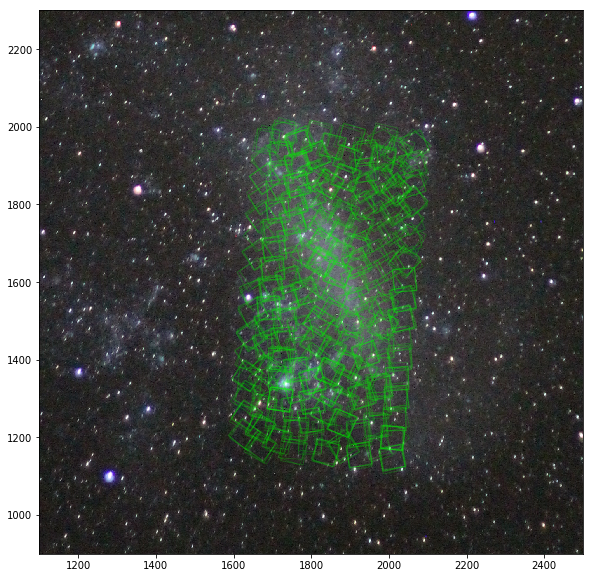

In [ ]:
# Plot the image Anna O'Grady took with her Camera of the LMC
# Needs to be transposed in order for the colors to work.
img = lmc_optical_hdu.data.T

# Zoom in on the galaxy
xdim = [1100,2500]
ydim = [900,2300]

# Plot Figure
plt.figure(figsize=(10,10))
plt.imshow(img)

# Plot Footprints
ax = plt.gca()
all_corners = lmc_um2_corners
for corner in all_corners:
    edge = np.flip(np.array(corner).T,axis=1)
    ax.add_patch(patches.Polygon(edge,facecolor=None,fill=False,edgecolor='lime',alpha=0.2)) 

# Formatting 
#ax.axis('off')
plt.xlim(xdim)
plt.ylim(ydim)

# To help rotate the image correctly I added an option to plot a line based on coordinates of a 2 degree line in ds9
# I do the rotation outside of python.
plot_ruler = False
if plot_ruler:
    y1,x1 = 1692.17,2248.75
    y2,x2 = 1277.08,2179
    m = (y2-y1)/(x2-x1)
    b = y1 - m * x1 
    xline = np.arange(x1,x2,(x2-x1)/10)
    y = m * xline + b
    ax.plot(xline,y,color='lime')

save = False
if save:
    plt.tight_layout()
    plt.savefig(f'lmc_coverage.png',transparent=True)

#### Step 7: Plot the SMC

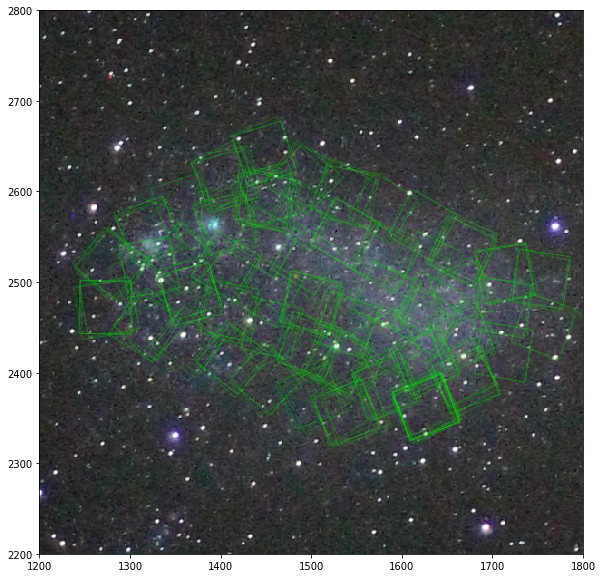

In [ ]:
# Plot the image Anna O'Grady took with her Camera of the SMC
# Needs to be transposed in order for the colors to work.
img = smc_optical_hdu.data.T

# Zoom in on the galaxy
xdim = [1200,1800]
ydim = [2200,2800]

# Plot Figure
plt.figure(figsize=(10,10))
plt.imshow(img)

# Plot Footprints
ax = plt.gca()
all_corners = smc_uw1_corners
for corner in all_corners:
    edge = np.flip(np.array(corner).T,axis=1)
    ax.add_patch(patches.Polygon(edge,facecolor=None,fill=False,edgecolor='lime',alpha=0.2)) 

# Formatting
#ax.axis('off')
plt.xlim(xdim)
plt.ylim(ydim)

# To help rotate the image correctly I added an option to plot a line based on coordinates of a 2 degree line in ds9
# I do the rotation outside of python.
plot_ruler = False
if plot_ruler:
    y1,x1 = 2326.17,1780.05
    y2,x2 = 2114.76,1421.44

    m = (y2-y1)/(x2-x1)
    b = y1 - m * x1 
    xline = np.arange(x1,x2,(x2-x1)/10)
    y = m * xline + b
    ax.plot(xline,y,color='lime')

save = False
if save: 
    plt.tight_layout()
    plt.savefig(f'smc_coverage_.png',transparent=True)